# Комп’ютерний практикум No 1. Навчання регресiйної моделi методами градiєнтного спуску в TensorFlow2
Недашкiвська Н.I.

## Хiд виконання роботи

Написати програму на Python, використовуючи TensorFlow2, яка задає i на-
вчає регресiйну модель методами градiєнтного спуску.

1. Завантажити початковi данi.
2. Представити данi графiчно.
3. Iнiцiалiзувати параметри: швидкiсть навчання, кiлькiсть епох (=100) i додатково, якщо задано згiдно з варiантом, кiлькiсть пакетiв i/або параметр регуляризацiї.

4. Iнiцiалiзувати вектор параметрiв.
5. Реалiзувати власний клас, наприклад, похiдний вiд tf.keras.Model.
6. Реалiзувати функцiю, яка задає модель, наприклад:
    - лiнiйну регресiю,
    - полiномiальну регресiю,
    - iншу криву, яку пiдiбрати вiдповiдно до заданих даних.
7. Задати функцiю втрат (одну згiдно з варiантом):
    - MSE,
    - MSE з регуляризацiєю за нормами L1 або L2.
8. Задати операцiю, яка буде викликатися на кожнiй iтерацiї алгоритма навчання:
    - алгоритм градiєнтного спуску,
    - алгоритм мiнi-пакетного градiєнтного спуску,
    - алгоритм градiєнтного спуску з моментом,
    - алгоритм Adagrad,
    - алгоритм Adadelta,
    - алгоритм Adam.
9. Виконати навчання моделi.
10. Розрахувати градiєнти використовуючи автоматичне диференцiювання i tf.GradientTape.

11. Виводити значення функцiї втрат через кожнi 10 епох - побудувати криву навчання.

12. В кiнцi навчання зберегти результуючу модель. Зберегти тiльки архiтектуру моделi в форматi JSON. Зберегти тiльки ваги моделi. Завантажити попередньо збережену модель.

13. Налаштувати гiперпараметр швидкiсть навчання i додатково, якщо задано згiдно варiанту, розмiр мiнi-пакета.

14. Дослiдити рiзнi значення параметра регуляризацiї i пiдiбрати найкраще з них, якщо згiдно з варiантом задано регуляризовану функцiю втрат. В цьому випадку данi мають бути попередньо розбитi на навчальний та перевiрочний набори.
15. Побудувати графiк з початковими даними та лiнiєю регресiї.

## Варіант 9 
Полiномiальна регресiя, алгоритм градiєнтного спуску з моментом, MSE
з регуляризацiєю за нормою L2.

(а)
```
X_data = np.linspace (−1, 1 , 101)
num_coef = 10
coef = [−100, 2, 3, −3000, 5, 6, 4, 300, 2, 600]
y_data = 0
for i in range(num_coef) :
    y_data += coef[i] * np.power(X_data, i )
y_data += np.random.randn(*X_data.shape) * 6.5
```
(б)
```
sklearn.datasets.make_friedman2
```

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [19]:
X_data = np.linspace (-1, 1 , 101)
num_coef = 10
coef = [-100, 2, 3, -3000, 5, 6, 4, 300, 2, 600]
y_data = 0
for i in range(num_coef) :
    y_data += coef[i] * np.power(X_data, i )
y_data += np.random.randn(*X_data.shape) * 6.5

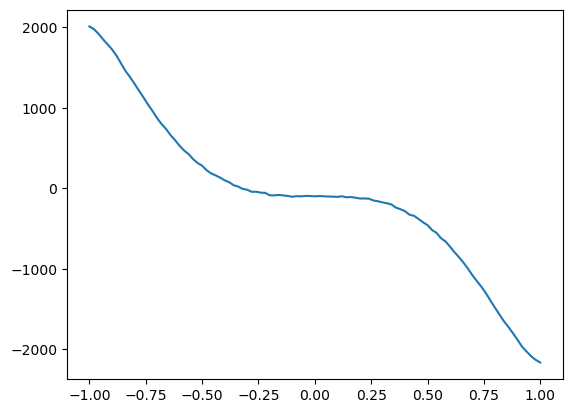

In [20]:
plt.plot(X_data, y_data, label="true");

## Model & Loss

In [21]:
# Define custom model class
class PolyRegression(tf.keras.Model):
    def __init__(self, num_coef=10):
        super().__init__()
        self.theta = tf.Variable(tf.random.normal([num_coef, 1]), dtype=tf.float32, name="weight")
        self.bias = tf.Variable(0.0, dtype=tf.float32, name="bias")

    def call(self, x):
        x_expanded = tf.expand_dims(x, axis=1)
        # Create polynomial features
        poly_features = tf.concat([tf.pow(x_expanded, i) for i in range(num_coef)], axis=1)
        # Compute predictions
        y_pred = tf.linalg.matmul(poly_features, self.theta)
        return y_pred + self.bias
    
    
# Define loss function
def mse_loss_term(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss


def l2_reg_loss_term(theta, l2_reg_param):
    l2_loss = tf.reduce_sum(tf.square(theta)) * l2_reg_param
    return l2_loss

In [22]:
def training_loop(
    model,
    optimizer,
    X_data,
    y_data,
    batch_size,
    epochs,
    l2_reg_param
):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        losses = []
        for i in range(0, len(X_data), batch_size):
            X_batch = X_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]

            with tf.GradientTape() as tape:
                y_pred = model(X_batch)
                loss = mse_loss_term(y_batch, y_pred) + l2_reg_loss_term(model.theta, l2_reg_param)
                losses.append(loss)

            gradients = tape.gradient(loss, [model.theta, model.bias])
            optimizer.apply_gradients(zip(gradients, [model.theta, model.bias]))

        loss = tf.reduce_mean(losses)
        history["train_loss"].append(loss.numpy())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
            
    return model, history

## Train

In [23]:
# Initialize parameters
epochs = 100
batch_size = 10
learning_rate = 0.01
momentum = 0.9
l2_reg_param = 0.01
num_coef = 10

# Define optimization algorithm
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

model = PolyRegression(num_coef)


model, history = training_loop(
    model,
    optimizer,
    X_data,
    y_data,
    batch_size,
    epochs,
    l2_reg_param
)

Epoch 0, Loss: 1214316.5000
Epoch 10, Loss: 74763.4297
Epoch 20, Loss: 72073.3750
Epoch 30, Loss: 71120.4688
Epoch 40, Loss: 70595.4609
Epoch 50, Loss: 70303.0312
Epoch 60, Loss: 70138.0547
Epoch 70, Loss: 70043.5625
Epoch 80, Loss: 69988.5078
Epoch 90, Loss: 69955.8047


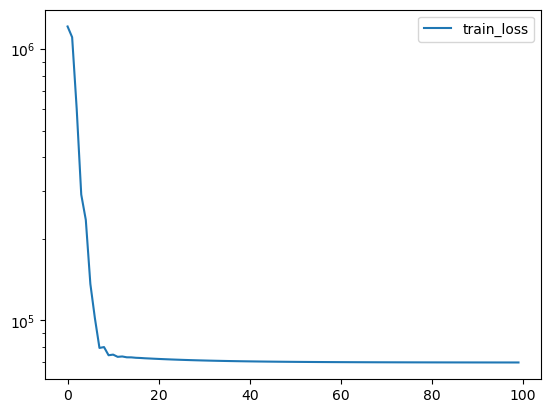

In [24]:
plt.plot(history["train_loss"], label="train_loss")
plt.legend()
plt.yscale("log")

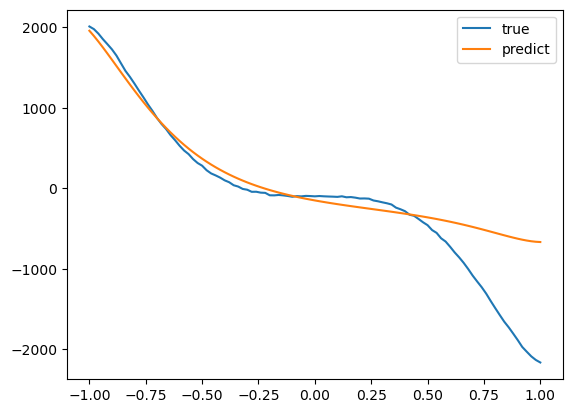

In [33]:
import matplotlib.pyplot as plt

plt.plot(X_data, y_data, label="true");
plt.plot(X_data, model(X_data), label="predict");
plt.legend();

## Save & Load

In [26]:
!rm model_weights.h5

In [27]:
# Save model architecture as JSON
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights('model_weights.h5')

# Load model architecture from JSON
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    
with tf.keras.utils.custom_object_scope({'PolyRegression': PolyRegression}):
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load model weights
loaded_model(X_data[:1])  # workaround for assigning variables to model
loaded_model.load_weights('model_weights.h5')

## Tune learning rate

In [28]:
# Initialize parameters
epochs = 100
batch_size = 10
momentum = 0.9
l2_reg_param = 0.01
num_coef = 10

results = {}
for learning_rate in [ 0.05, 0.01, 0.001, 3e-4]:
    # Define optimization algorithm
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model = PolyRegression(num_coef)

    model, history = training_loop(
        model,
        optimizer,
        X_data,
        y_data,
        batch_size,
        epochs,
        l2_reg_param
    )
    results[learning_rate] = history["train_loss"][-1]
    
results

Epoch 0, Loss: 647194.1250
Epoch 10, Loss: 70115190112256.0000
Epoch 20, Loss: 24982220278997025734787072.0000
Epoch 30, Loss: inf
Epoch 40, Loss: inf
Epoch 50, Loss: inf
Epoch 60, Loss: inf
Epoch 70, Loss: nan
Epoch 80, Loss: nan
Epoch 90, Loss: nan
Epoch 0, Loss: 1214692.0000
Epoch 10, Loss: 74798.8359
Epoch 20, Loss: 72092.0938
Epoch 30, Loss: 71130.8047
Epoch 40, Loss: 70601.1953
Epoch 50, Loss: 70306.2188
Epoch 60, Loss: 70139.8203
Epoch 70, Loss: 70044.5547
Epoch 80, Loss: 69989.0859
Epoch 90, Loss: 69956.1172
Epoch 0, Loss: 1259320.1250
Epoch 10, Loss: 100561.8672
Epoch 20, Loss: 80549.7422
Epoch 30, Loss: 76571.9688
Epoch 40, Loss: 75010.5234
Epoch 50, Loss: 74136.6719
Epoch 60, Loss: 73530.2422
Epoch 70, Loss: 73064.4219
Epoch 80, Loss: 72687.7500
Epoch 90, Loss: 72372.8047
Epoch 0, Loss: 1244366.7500
Epoch 10, Loss: 364716.8750
Epoch 20, Loss: 169798.2344
Epoch 30, Loss: 113936.3984
Epoch 40, Loss: 95081.4297
Epoch 50, Loss: 87171.2969
Epoch 60, Loss: 83031.7422
Epoch 70, Los

{0.05: nan, 0.01: 69937.71, 0.001: 72127.95, 0.0003: 76801.86}

`learning_rate = 0.01` є оптимальним значенням 

## Tune l2 regularization

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = X_data[:80], X_data[80:], y_data[:80], y_data[80:]

In [32]:
# Initialize parameters
epochs = 100
batch_size = 10
learning_rate = 0.01
momentum = 0.9
num_coef = 10

results = {}
for l2_reg_param in [1, 0.1, 0.01, 0.001, 0]:
    # Define optimization algorithm
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model = PolyRegression(num_coef)

    model, history = training_loop(
        model,
        optimizer,
        X_train,
        y_train,
        batch_size,
        epochs,
        l2_reg_param
    )
    
    results[l2_reg_param] = mse_loss_term(y_test, model(X_test)).numpy()
    
results

Epoch 0, Loss: 704606.6250
Epoch 10, Loss: 367918.0625
Epoch 20, Loss: 366511.6875
Epoch 30, Loss: 366530.7500
Epoch 40, Loss: 366531.4375
Epoch 50, Loss: 366531.4375
Epoch 60, Loss: 366531.4062
Epoch 70, Loss: 366531.4062
Epoch 80, Loss: 366531.4375
Epoch 90, Loss: 366531.4062
Epoch 0, Loss: 642723.4375
Epoch 10, Loss: 119495.9766
Epoch 20, Loss: 119064.8047
Epoch 30, Loss: 119068.0781
Epoch 40, Loss: 119066.0938
Epoch 50, Loss: 119065.5312
Epoch 60, Loss: 119065.3594
Epoch 70, Loss: 119065.2969
Epoch 80, Loss: 119065.2734
Epoch 90, Loss: 119065.2578
Epoch 0, Loss: 638163.3750
Epoch 10, Loss: 53792.6719
Epoch 20, Loss: 52099.7344
Epoch 30, Loss: 51395.6445
Epoch 40, Loss: 51006.5312
Epoch 50, Loss: 50780.8828
Epoch 60, Loss: 50644.1406
Epoch 70, Loss: 50558.0703
Epoch 80, Loss: 50502.1797
Epoch 90, Loss: 50464.9648
Epoch 0, Loss: 638344.7500
Epoch 10, Loss: 45891.6367
Epoch 20, Loss: 43433.2227
Epoch 30, Loss: 42035.2773
Epoch 40, Loss: 41016.8008
Epoch 50, Loss: 40239.8125
Epoch 60, 

{1: 2314556.2, 0.1: 1364332.2, 0.01: 1130848.6, 0.001: 1086050.6, 0: 1078904.0}

Відсутність регуляризації показує кращі результати в цьому випадку

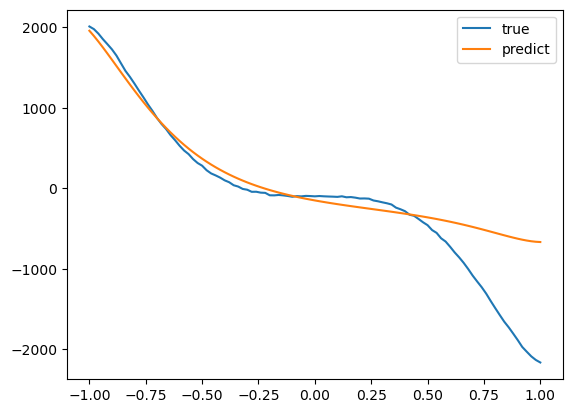

In [34]:
import matplotlib.pyplot as plt

plt.plot(X_data, y_data, label="true");
plt.plot(X_data, model(X_data), label="predict");
plt.legend();